# Nussl Exploration

This notebook was used to explore using Nussl pre-trained models to split audio signals. Many of the available models present several issues when trying to use locally - such as package installation issues, models not found even when path properly outlined etc. The Independent Component Analysis (ICA) separator works but will only separate vocals from other stems, and will not isolate drums or bass from other accompaniment.

In [5]:
# Installs required:
# numpy==1.19.3
# ffmpeg
# nussl
# SoX

import nussl
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np
import os
import vamp
import tensorflow as tf

## Benchmark Examples

### High pass filter separator

In [3]:
start_time = time.time()

In [12]:
def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='mel', db_cutoff=-40, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)

In [13]:
musdb = nussl.datasets.MUSDB18(
    download=True, sample_rate=16000,
    strict_sample_rate = False
)
i = 39
item = musdb[i]
mix = item['mix']

c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


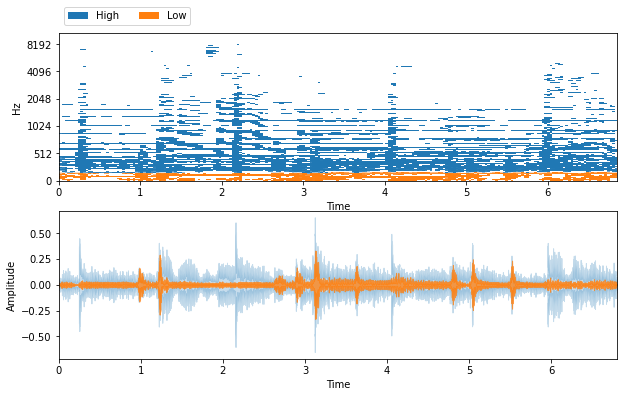


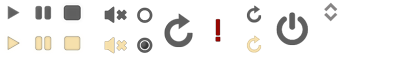
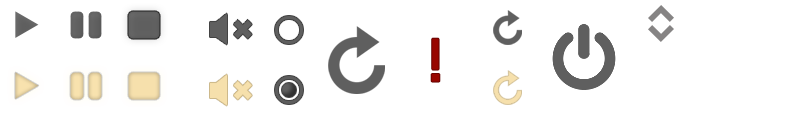
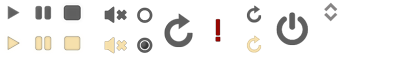

In [6]:
separator = nussl.separation.benchmark.HighLowPassFilter(
    mix, 100)
estimates = separator()
estimates = {
    'Low': estimates[0],
    'High': estimates[1]
}
visualize_and_embed(estimates)

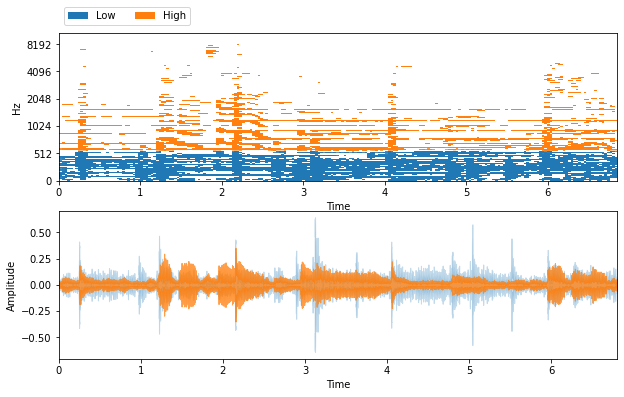


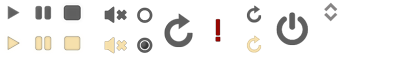
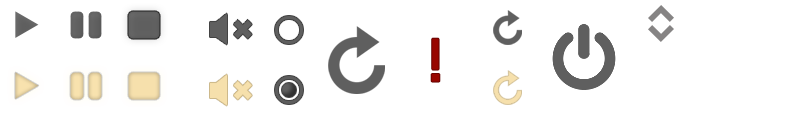
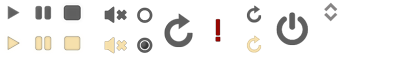

In [7]:
separator = nussl.separation.benchmark.HighLowPassFilter(
    mix, 400)
estimates = separator()
estimates = {
    'Low': estimates[0],
    'High': estimates[1]
}
visualize_and_embed(estimates)

In [8]:
end_time = time.time()
time_taken = end_time - start_time
print(f'Time taken: {time_taken:.4f} seconds')

Time taken: 2429.7321 seconds


### Mix as estimate separator

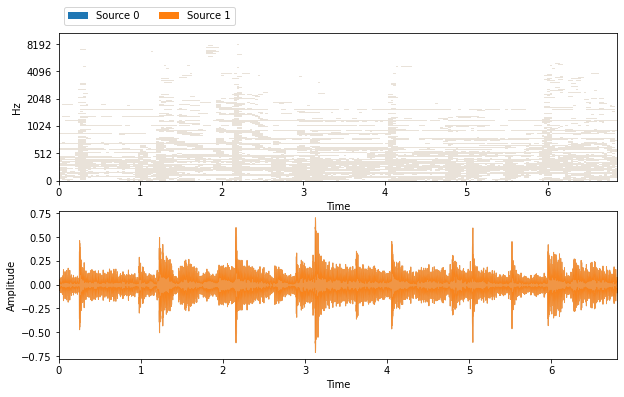


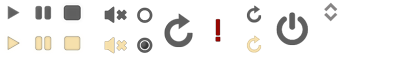
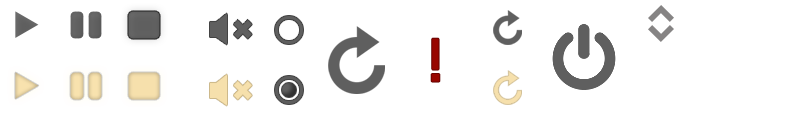
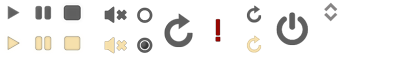

In [10]:
separator = nussl.separation.benchmark.MixAsEstimate(
    mix, num_sources=2)
estimates = separator()
estimates = {
    f'Source {i}': e for i, e in enumerate(estimates)
}
visualize_and_embed(estimates)

## Factorization

### Independent Component Analysis (ICA)

In [19]:
i = 3
item = musdb[i]
sources = [item['sources']['other'], item['sources']['vocals'], item['sources']['drums'], item['sources']['bass']]

a = nussl.mixing.pan_audio_signal(sources[0], -35)
a_delays = [np.random.randint(1, 20) for _ in range(a.num_channels)]
a = nussl.mixing.delay_audio_signal(a, a_delays)

b = nussl.mixing.pan_audio_signal(sources[1], 35)
b_delays = [np.random.randint(1, 20) for _ in range(b.num_channels)]
b = nussl.mixing.delay_audio_signal(b, b_delays)

c = nussl.mixing.pan_audio_signal(sources[2], -25)
c_delays = [np.random.randint(1, 20) for _ in range(c.num_channels)]
c = nussl.mixing.delay_audio_signal(c, c_delays)

d = nussl.mixing.pan_audio_signal(sources[3], 25)
d_delays = [np.random.randint(1, 20) for _ in range(d.num_channels)]
d = nussl.mixing.delay_audio_signal(d, d_delays)

mix = a + b + c + d

audio_signals = [
    mix.make_audio_signal_from_channel(ch)
    for ch in range(mix.num_channels)
]

c:\users\njeri\.venvs\mixs_env\lib\site-packages\nussl\core\audio_signal.py:1333: UserWarning: Shape of new audio_data does not match current audio_data.
  warnings.warn('Shape of new audio_data does not match current audio_data.')
c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


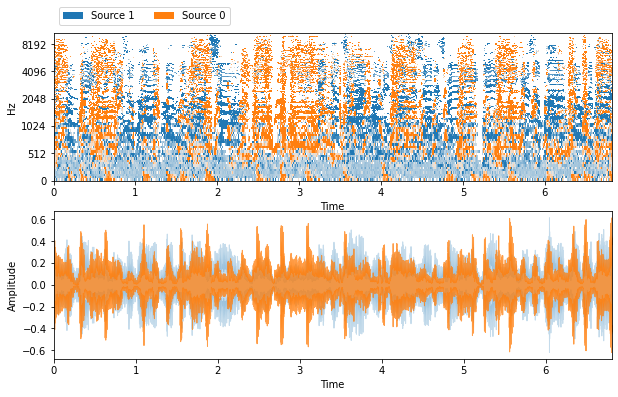


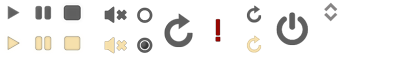
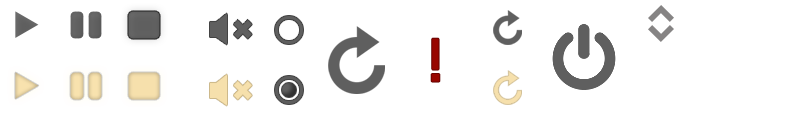
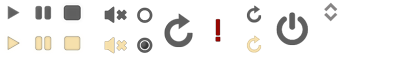

In [27]:
separator = nussl.separation.factorization.ICA(audio_signals)
estimates = separator()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

### Robust Principal Component Analysis (RPCA)

Matching file found at C:\Users\njeri\.nussl\audio\schoolboy_fascination_excerpt.wav, skipping download.


c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


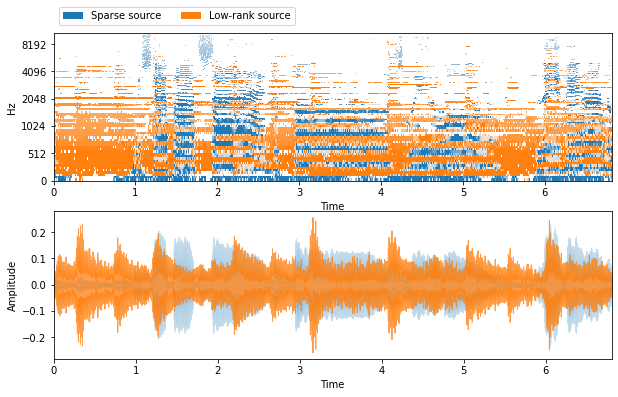


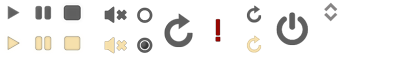
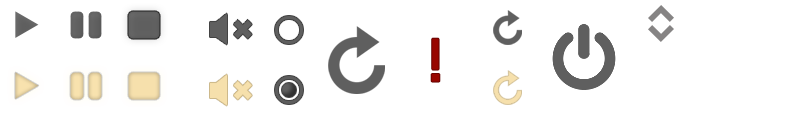
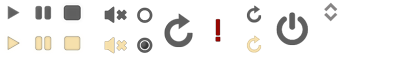

In [17]:
audio_path = nussl.efz_utils.download_audio_file(
    'schoolboy_fascination_excerpt.wav')
audio_signal = nussl.AudioSignal(audio_path)

separator_rpca = nussl.separation.factorization.RPCA(audio_signal)
estimates_rpca = separator()

estimates_rpca = {
    'Low-rank source': estimates_rpca[0],
    'Sparse source': estimates_rpca[1]
}

visualize_and_embed(estimates_rpca)

## Ensemble Clustering

In [8]:
# Requires vamp and Melodia installation

audio_path = nussl.efz_utils.download_audio_file(
    'schoolboy_fascination_excerpt.wav')
audio_signal = nussl.AudioSignal(audio_path)

separators = [
    nussl.separation.primitive.FT2D(audio_signal),
    nussl.separation.primitive.HPSS(audio_signal),
    nussl.separation.primitive.Melodia(audio_signal),
]

weights = [2, 1, 2]
returns = [[1], [0], [1]]

fixed_centers = np.array([
    [0 for i in range(sum(weights))],
    [1 for i in range(sum(weights))],
])
                
ensemble = nussl.separation.composite.EnsembleClustering(
    audio_signal, 2, separators=separators, init=fixed_centers,
    fit_clusterer=False, weights=weights, returns=returns)
ensemble.clusterer.cluster_centers_ = fixed_centers
estimates = ensemble()

estimates = {
    f'Cluster {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

Matching file found at C:\Users\njeri\.nussl\audio\schoolboy_fascination_excerpt.wav, skipping download.


SeparationException: 
**~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~**
*          Are Vamp and Melodia installed correctly?          *
* Check https://bit.ly/2DXbrAk for installation instructions! *
**~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~**

## Deep Learning

### Deep clustering

In [7]:
def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-40, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    nussl.play_utils.multitrack(sources)

In [8]:
model_path = nussl.efz_utils.download_trained_model(
    'dpcl-wsj2mix-model.pth')

model_path

Matching file found at C:\Users\njeri\.nussl\models\dpcl-wsj2mix-model.pth, skipping download.


'C:\\Users\\njeri\\.nussl\\models\\dpcl-wsj2mix-model.pth'

In [9]:
audio_path = nussl.efz_utils.download_audio_file(
    'wsj_speech_mixture_ViCfBJj.mp3')
audio_signal = nussl.AudioSignal(audio_path)

Matching file found at C:\Users\njeri\.nussl\audio\wsj_speech_mixture_ViCfBJj.mp3, skipping download.


c:\users\njeri\.venvs\mixs_env\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [10]:
model = tf.keras.models.load_model(model_path, custom_objects=None, compile=True, options=None)
separator = nussl.separation.deep.DeepClustering(audio_signal, 2, model_path=model)

OSError: SavedModel file does not exist at: C:\Users\njeri\.nussl\models\dpcl-wsj2mix-model.pth/{saved_model.pbtxt|saved_model.pb}

In [ ]:
estimates = separator()

estimates = {
    f'Speaker {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

### Deep mask estimation

In [11]:
model_path = nussl.efz_utils.download_trained_model(
    'mask-inference-wsj2mix-model-v1.pth')
audio_path = nussl.efz_utils.download_audio_file(
    'wsj_speech_mixture_ViCfBJj.mp3')
audio_signal = nussl.AudioSignal(audio_path)
separator = nussl.separation.deep.DeepMaskEstimation(
    audio_signal, mask_type='soft', model_path=model_path)
estimates = separator()

estimates = {
    f'Speaker {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

Saving file at C:\Users\njeri\.nussl\models\mask-inference-wsj2mix-model-v1.pth
mask-inference-wsj2mix-model-v1.pth...100%
Matching file found at C:\Users\njeri\.nussl\audio\wsj_speech_mixture_ViCfBJj.mp3, skipping download.


SeparationException: Failed loading model. Expected to find 'nussl_version' in C:\Users\njeri\.nussl\models\mask-inference-wsj2mix-model-v1.pth.